In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import pandas as pd

In [3]:
import yfinance as yf

# Set the start and end dates for the historical data
start_date = '2021-06-14'
end_date = '2023-06-13'

# Fetch the historical SPY data from Yahoo Finance
spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1h')

# Reformat the data to fit the sma_crossover_backtester() function
spy_data = spy_data.reset_index()
spy_data['timestamp'] = spy_data['Datetime']
spy_data['price'] = spy_data['Open']



[*********************100%***********************]  1 of 1 completed


In [21]:
import numpy as np

def mean_reversion_backtester(sampled_data, 
                            order_sizing, 
                            ma_length, 
                            starting_capital,
                            buy_threshold,
                            take_profit,
                            stop_loss,
                            shorting_allowed,
                            fixed_fee,
                            display_results,
                            record_balance,
                            show_moving_averages,
                            annual_taxes,
                            tax_percentage = 0,
                            fee=0
                            ):
    """ 
    Parameters:
        sampled_data: pandas dataframe that must have columns 'timestamp' and 'price'
        order_sizing: how much of available capital to use on a given trade (betwen 0 and 1)
        ma_length: moving average length (in hours)
        starting_capital: how much capital to start with (USD)
        buy_threshold: at what % below the moving average to buy (if 5%, should be 0.05)
        take_profit: at what % gain to sell and take the profit (if 5%, should be 0.05)
        stop_loss: at what % to sell and stop losses (if 5%, should be 0.05)
        shorting_allowed: whether or not to short or sell regularly (true or false)
        fee: the % charged per transaction by the exchange (in %, so 0.01 = 1%)
        record_balance: whether or not to track the balance over the whole period
        show_moving_averages: whether or not to show the moving averages in the plot displayed (true or false)
        annual_taxes: whether or not to take annual taxes on gains (true or false)
        tax_percentage: if taxes are enabled, what % of taxes to pay on gains (0.01 = 1%), default = 0
    Returns:
        backtest_results: dictionary that contains backtest result metrics and balance information 
    """

    # for figuring out how much a fee is
    # we are taking the average of maker and taker fees on coinbase pro starting on 6/5/23
    def find_fee(thirty_day_volume):
        volume_fee_table = {
            10000: 0.005,
            50000: 0.00325,
            100000: 0.002,
            1000000: 0.0015,
            15000000: 0.0013,
            75000000: 0.0011,
            250000000: 0.00075,
            400000000: 0.0004,
        }
        
        for volume, fee in volume_fee_table.items():
            if thirty_day_volume <= volume:
                return fee
        
        # If the volume is greater than the largest key, return the fee for the largest key
        return volume_fee_table[400000000]
    
    import math 
    import statistics 
    import numpy as np
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    # Ensure inputs are valid
    if "timestamp" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'timestamp' column missing from data."
    if "price" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'price' column missing from data."
    if starting_capital <= 0:
        return "Could not run ma_crossover_backtester(), starting_capital must be greater than zero."
    if order_sizing > 1 or order_sizing <= 0:
        return "Could not run ma_crossover_backtester(), order_sizing must be between 1 and 0."
    
    
    fiat = starting_capital
    position_size = 0
    baseline_position_size = 0
    portfolio_balance = [] #keeps track of the total portfolio worth
    baseline_balance = [] #keeps track of the buy and hold balance
    moves = [] #keep track of buys and sells
    trades = 0
    purchase_price = 0
    wins = 0
    losses = 0

    # setup for keeping track of quarterly results
    three_month_hours = 2191
    one_month_hours = 730 #actually 730.5 
    quarter_numbers = []
    quarter_return_rates = []
    quarter_trades = []
    quarter_hit_rates = []
    baseline_return_rates = []

    monthly_return_rates = []

    # calculate the total number of quarters in the dataset
    total_quarters = math.floor(len(sampled_data.index)/three_month_hours)
    total_months = math.floor(len(sampled_data.index)/one_month_hours)

    # calculate quarter intervals
    quarter_intervals = [three_month_hours*x for x in range(0, total_quarters)]
    monthly_intervals = [one_month_hours*x for x in range(0, total_months)]

    # convert to get the corresponding timestamps
    quarter_intervals = [sampled_data.iloc[x]['timestamp'] for x in quarter_intervals]
    monthly_intervals = [sampled_data.iloc[x]['timestamp'] for x in monthly_intervals]
    
    current_price = sampled_data['price'][0]
    baseline_position_size = starting_capital/current_price
    baseline_initial = current_price

    ma = sampled_data.price.rolling(ma_length).mean()

    #truncate the data so they all are aligned 
    ma = list(ma[ma_length:])
    sampled_data = sampled_data[ma_length:]
    last_average_higher = "None"

    # set up shorting mechanism
    short_position = None
    short_results = []

    # set up volume data
    thirty_day_volume = 0
    volume_data = []

    # set up tax information, when the year changes, we check if we gained or lost for the year, and then put that aside for taxes
    sampled_data['timestamp'] = pd.to_datetime(sampled_data['timestamp'])

    past_year = sampled_data.iloc[0]['timestamp'].year
    annual_change = 0
    
    #now run through each moment in the data and check if there is a crossover
    for x in range(0, len(sampled_data['price'])):

        if position_size*current_price + fiat == 0:
            print("Error at position:", x)
            print(sampled_data.iloc[x])
            print(last_move)
            break

        # calculate the fee using the thirty_day_volume
        if not fixed_fee:
            fee = find_fee(thirty_day_volume)

        #get the current price
        current_price = sampled_data.iloc[x]['price']

        if x == 0:
            #baseline_initial = current_price
            #baseline_position_size = starting_capital/current_price
            quarter_initial = current_price

            monthly_initial_balance = starting_capital
            quarter_initial_balance = starting_capital
            quarter_baseline_initial_balance = starting_capital

            annual_baseline_balance = starting_capital
        
        # if the year has changed, calculate how much has happened
        if annual_taxes == True:
            current_year = sampled_data.iloc[x]['timestamp'].year
            if current_year != past_year:
                # the year has changed
                if short_position == True:
                    short_delta = (purchase_price*position_size - current_price*position_size)
                    current_balance = (purchase_price*position_size + short_delta + fiat)
                else:
                    current_balance = current_price*position_size + fiat

                annual_change = current_balance - annual_baseline_balance

                # if we had a gain that year, you need to pay taxes
                if annual_change > 0:
                    taxes_due = annual_change*tax_percentage
                    
                    # if currently holding a position, will need to sell some of it to make up for the taxes...(since fiat is probably low)
                    if position_size != 0:
                        taxes_due = annual_change*tax_percentage - fiat #use all fiat first
                        amount_to_sell = taxes_due/current_price # find out how many shares will cover the amount due
                        position_size = position_size - amount_to_sell # reduce that many shares from the amount due
                    else:
                        fiat = fiat - taxes_due
                
                # reset the new amount
                annual_baseline_balance = position_size*current_price + fiat
            
            past_year = current_year
        
        # if a new month begins, calculate the return for that month (for sharpe ratio calculations)
        if sampled_data.iloc[x]['timestamp'] in monthly_intervals:
            monthly_return_rate = ((fiat + current_price*position_size)/monthly_initial_balance) - 1
            monthly_return_rates.append(monthly_return_rate)
            monthly_initial_balance = fiat + current_price*position_size

        # If a new quarter begins, calculate metrics for the quarter
        if sampled_data.iloc[x]['timestamp'] in quarter_intervals:
            quarter_return_rate = ((fiat + current_price*position_size)/quarter_initial_balance) - 1
            quarter_return_rates.append(quarter_return_rate)
            quarter_trades.append(trades)
            baseline_return_rate = ((baseline_position_size*current_price)/quarter_baseline_initial_balance) - 1
            baseline_return_rates.append(baseline_return_rate)

            if (losses + wins) > 0:
                hit_rate = wins/(losses + wins)
            else:
                hit_rate = "N/A"

            quarter_hit_rates.append(hit_rate)

            # reset initial price for the quarter
            quarter_initial = current_price

            # reset number of trades, losses, wins
            trades = 0
            losses = 0
            wins = 0

            # calculate the new initial portfolio worth to be used for the new quarter
            quarter_initial_balance = fiat + current_price*position_size
            quarter_baseline_initial_balance = current_price*baseline_position_size
            
            
        #keep track of which one was higher previously
        if x == 0:
            last_move = "Pass"

        else:
            #begin the trading mechanism

            #if the price dips below a set % from the moving average - BUY
            if last_move != "Buy" and current_price <= ma[x]*(1-buy_threshold):
                if shorting_allowed == True:
                    if short_position == True:
                        # if there is a short position, exit out of it
                        short_delta = (purchase_price*position_size - current_price*position_size) # calculate the delta for the short
                        short_results.append(short_delta)
                        fiat = fiat + (purchase_price*position_size + short_delta)*(1 - fee) # sell the position and the short
                        position_size = 0 # set the position to zero
                    short_position = False 

                #add the btc amount to the position
                position_size = position_size + (order_sizing*fiat*(1 - fee))/current_price #add the btc purchased
                fiat = fiat - order_sizing*fiat #subtract the amount of capital used
                last_move = "Buy"
                trades = trades + 1
                purchase_price = current_price

            #if the take profit or stop loss threshold is crossed - SELL
            elif last_move == "Buy" and (current_price >= ma[x]*(1+take_profit) or current_price <=ma[x]*(1-stop_loss)):
                fiat = fiat + position_size*current_price*(1 - fee)
                position_size = 0

                if shorting_allowed == True:
                    position_size = (order_sizing*fiat*(1 - fee))/current_price
                    fiat = fiat - position_size*current_price
                    last_move = "Short-Sell"
                    short_position = True
                    purchase_price = current_price
                else:
                    last_move = "Sell"# reset the purchase price
                    purchase_price = 0

                trades = trades + 1

                # record whether the trade was profitable
                if purchase_price < current_price:
                    wins = wins + 1 
                else:
                    losses = losses + 1
                
            else:
                pass
                #moves.append("Pass")
        
        if shorting_allowed == True:
            #record the portfolio information
            if short_position == False or short_position == None:
                if record_balance == True:
                    portfolio_balance.append(position_size*current_price + fiat)
            if short_position == True:
                short_delta = (purchase_price*position_size - current_price*position_size)
                if record_balance == True:
                    portfolio_balance.append(purchase_price*position_size + short_delta + fiat)
        else:
            #record the portfolio information
            if record_balance == True:
                portfolio_balance.append(position_size*current_price + fiat)
            
        if record_balance == True:
            baseline_balance.append(baseline_position_size*current_price)

        # go through the volume data
        thirty_day_volume = 0 # re-calculate the current thirty_day_volume
        new_volume_data = []
        for volume_data_entry in volume_data:
            if volume_data_entry[0] < 720: # 720 hours in thirty days
                thirty_day_volume = thirty_day_volume + volume_data_entry[1]
                new_volume_data.append([volume_data_entry[0] + 1, volume_data_entry[1]])
        
        volume_data = new_volume_data
        
    
    # compute final results
    baseline_final = current_price
    baseline_return_rate = (baseline_final/baseline_initial) - 1  
    final_return_rate = ((position_size*current_price + fiat)/starting_capital) - 1
    if (losses + wins) > 0:
        hit_rate = wins/(losses + wins)
    else:
        hit_rate = "N/A"

    # calculate sharpe ratio (using 0% as the risk-free return benchmark)
    sharpe_ratio = (statistics.mean(monthly_return_rates)-0)/(statistics.stdev(monthly_return_rates)*np.sqrt(12))


    if display_results == True and record_balance == True:
        plot_data = pd.DataFrame()
        plot_data['time'] = sampled_data['timestamp']
        plot_data['Mean Reversion'] = portfolio_balance
        plot_data['Baseline'] = baseline_balance
        if show_moving_averages:
            plot_data["Moving Average"] = [i*baseline_position_size for i in ma]
        plot_data.plot(x = "time")
        plt.xticks(rotation="vertical")
        plt.show()
    else:
        plot_data = "Could not generate plot_data: display_results and/or record_balance was set to False."

    # return the results
    backtest_results = {"final_return_rate" : final_return_rate,
               "hit_rate": hit_rate,
               "baseline_return_rate": baseline_return_rate,
               "quarter_return_rates": quarter_return_rates, 
               "quarter_trades": quarter_trades,
               "quarter_hit_rates": quarter_hit_rates,
               "baseline_return_rates": baseline_return_rates,
               "balance_data": plot_data,
               "sharpe_ratio": sharpe_ratio

    }
    
    return backtest_results

def plot_quarterly_data(backtest_results):
    '''
    Visualize quarterly data from a backtest run.

    Parameters:
        backtest_results: dict generated by sma_crossover_backtester()
    Returns:
        None
    '''

    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    quarterly_data = pd.DataFrame()
    quarterly_data['quarter'] = [x + 1 for x in range(0, len(backtest_results["quarter_return_rates"]))]
    quarterly_data['return'] = [x*100 for x in backtest_results["quarter_return_rates"]]
    quarterly_data['trades'] = backtest_results["quarter_trades"]
    quarterly_data['hit_rate'] = backtest_results["quarter_hit_rates"]
    quarterly_data['baseline'] = [x*100 for x in backtest_results["baseline_return_rates"]]

    # Hit Rate
    # if there are NAs in the hit rate, ignore it.
    if 'N/A' not in backtest_results['quarter_hit_rates']:
        clrs = ['green' if (x > 0) else 'red' for x in quarterly_data['return']]
        graph = sns.barplot(x="quarter",y="hit_rate",data=quarterly_data,palette=clrs)
        #Drawing a horizontal line at 0.5
        graph.axhline(0.5)
        plt.show()

    # Returns
    clrs = ['green' if (x > 0) else 'red' for x in quarterly_data['return']]
    graph = sns.barplot(x="quarter",y="return",data=quarterly_data,palette=clrs)
    plt.show()

    # Number of trades
    graph = sns.barplot(x="quarter",y="trades",data=quarterly_data,palette=clrs)
    plt.show()

    # Comparing quarterly returns
    comparison_df = pd.DataFrame()
    comparison_df['Return (%)']  = list(quarterly_data['return']) + list(quarterly_data['baseline'])
    comparison_df['Quarter'] = [x for x in quarterly_data['quarter']] + [x for x in quarterly_data['quarter']]
    comparison_df['Strategy'] = ["Mean Reversion" for x in quarterly_data['quarter']] + ["Buy and Hold" for x in quarterly_data['quarter']]

    sns.barplot(data=comparison_df, x='Quarter', y='Return (%)', hue='Strategy')
    plt.show()

/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


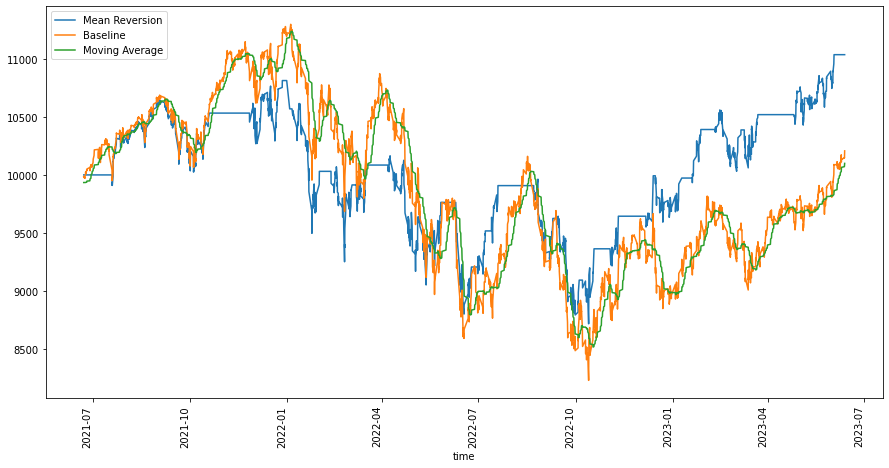

{'final_return_rate': 0.10373796570682048,
 'hit_rate': 1.0,
 'baseline_return_rate': 0.020757245507208255,
 'quarter_return_rates': [],
 'quarter_trades': [],
 'quarter_hit_rates': [],
 'baseline_return_rates': [],
 'balance_data':                           time  Mean Reversion      Baseline  Moving Average
 48   2021-06-22 15:30:00-04:00    10000.000000   9985.628128     9934.301276
 49   2021-06-23 09:30:00-04:00    10000.000000   9974.082743     9934.200643
 50   2021-06-23 10:30:00-04:00    10000.000000   9982.094120     9934.286102
 51   2021-06-23 11:30:00-04:00    10000.000000   9971.491377     9934.200208
 52   2021-06-23 12:30:00-04:00    10000.000000   9975.379145     9934.197752
 ...                        ...             ...           ...             ...
 3506 2023-06-12 11:30:00-04:00    11037.379657  10146.549521    10081.078459
 3507 2023-06-12 12:30:00-04:00    11037.379657  10159.036829    10085.829926
 3508 2023-06-12 13:30:00-04:00    11037.379657  10162.153802    1

In [22]:
# without shorting
backtest_results = mean_reversion_backtester(
            sampled_data = spy_data,
            order_sizing = 1,
            ma_length = 48,
            buy_threshold = 0.01,
            take_profit=0.02,
            stop_loss=0.1, 
            starting_capital = 10000,
            shorting_allowed=False,
            fixed_fee=True,
            fee = 0,
            display_results=True,
            record_balance=True,
            show_moving_averages=True,
            annual_taxes=True,
            tax_percentage=0.3
        )

backtest_results


/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


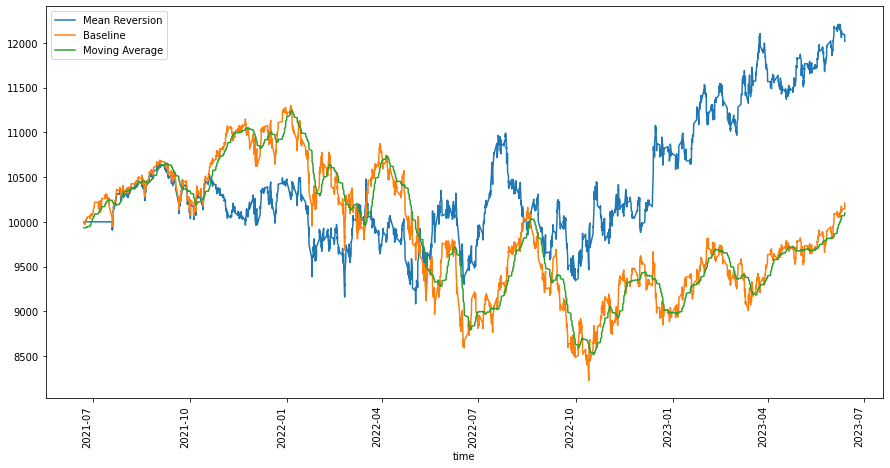

{'final_return_rate': 0.23412101014092146,
 'hit_rate': 0.0,
 'baseline_return_rate': 0.020757245507208255,
 'quarter_return_rates': [],
 'quarter_trades': [],
 'quarter_hit_rates': [],
 'baseline_return_rates': [],
 'balance_data':                           time  Mean Reversion      Baseline  Moving Average
 48   2021-06-22 15:30:00-04:00    10000.000000   9985.628128     9934.301276
 49   2021-06-23 09:30:00-04:00    10000.000000   9974.082743     9934.200643
 50   2021-06-23 10:30:00-04:00    10000.000000   9982.094120     9934.286102
 51   2021-06-23 11:30:00-04:00    10000.000000   9971.491377     9934.200208
 52   2021-06-23 12:30:00-04:00    10000.000000   9975.379145     9934.197752
 ...                        ...             ...           ...             ...
 3506 2023-06-12 11:30:00-04:00    12091.389495  10146.549521    10081.078459
 3507 2023-06-12 12:30:00-04:00    12076.292029  10159.036829    10085.829926
 3508 2023-06-12 13:30:00-04:00    12072.523530  10162.153802    1

In [23]:
# with shorting
backtest_results = mean_reversion_backtester(
            sampled_data = spy_data,
            order_sizing = 1,
            ma_length = 48,
            buy_threshold = 0.01,
            take_profit=0.02,
            stop_loss=0.1, 
            starting_capital = 10000,
            shorting_allowed=True,
            fixed_fee=True,
            fee = 0,
            display_results=True,
            record_balance=True,
            show_moving_averages=True,
            annual_taxes=True,
            tax_percentage=0.3
        )

backtest_results


In [26]:
def random_ma_length_generator():
    """
    Generate random moving averages for optimization purposes.
    """
    import random
    num1 = random.randrange(0, round(2191/2))
    num2 = random.randrange(0, round(2191/2))
    while num2 < num1:
        num2 = random.randrange(0, round(2191/2))
    
    return num1, num2



def run_multiple_backtests(shorting_allowed, num_runs):
    """
    shorting_allowed: bool
    num_runs: int
    """
    from tqdm import trange # for tracking progress
    import statistics
    import random


        # test lots of combinations
    ma_combinations = []
    buy_thresholds = []
    stop_loss_thresholds = []
    take_profit_thresholds = []
    median_return_rate_results = []
    stdev_return_rate_results = []
    profitable_quarters_results = [] 
    cumulative_return_results = []
    cumulative_baseline_return_results = []
    sharpe_ratios = []
    total_trades_results = []
    mean_trades_results = []

    # run 100 different combinations (this can take up to a few hours, depending on the number of combinations being tested)
    for x in trange(100):
        stop_loss = round(random.randrange(0, 100),2)/100
        buy_threshold = round(random.randrange(0, 100),2)/100
        take_profit = round(random.randrange(0, 100),2)/100
        ma_length = random.randrange(0, round(2191/2))

        ma_combinations.append(ma_length)
        buy_thresholds.append(buy_threshold)
        stop_loss_thresholds.append(stop_loss)
        take_profit_thresholds.append(take_profit)

        backtest_results = mean_reversion_backtester(
                sampled_data = spy_data,
                order_sizing = 1,
                ma_length = ma_length,
                buy_threshold = buy_threshold,
                take_profit = take_profit, 
                stop_loss = stop_loss,
                starting_capital = 10000,
                shorting_allowed=shorting_allowed,
                fixed_fee=False,
                record_balance=False,
                fee = 0,
                display_results = False,
                show_moving_averages=False,
                annual_taxes=True,
                tax_percentage=0.3
            )
        
        #median_return_rate = statistics.median(backtest_results['quarter_return_rates'])
        #stdev_return_rate = statistics.stdev(backtest_results['quarter_return_rates'])
        profitable_quarters = len([x for x in backtest_results['quarter_return_rates'] if x > 0])
        cumulative_return = backtest_results['final_return_rate']
        cumulative_baseline_return = backtest_results["baseline_return_rate"]
        #sharpe_ratio = backtest_results["sharpe_ratio"]
        total_trades = sum([x for x in backtest_results['quarter_trades']])
        #mean_trades_per_quarter = total_trades/len(backtest_results['quarter_trades'])

        #median_return_rate_results.append(median_return_rate)
        #stdev_return_rate_results.append(stdev_return_rate)
        profitable_quarters_results.append(profitable_quarters)
        cumulative_return_results.append(cumulative_return)
        cumulative_baseline_return_results.append(cumulative_baseline_return)
        #sharpe_ratios.append(sharpe_ratio)
        total_trades_results.append(total_trades)
        #mean_trades_results.append(mean_trades_per_quarter)

    # compile results into a table for exploration
    optimization_results = pd.DataFrame()
    optimization_results["ma"] = ma_combinations
    optimization_results["buy_threshold"] = buy_thresholds
    optimization_results["take_profit_threshold"] = take_profit_thresholds
    optimization_results["stop_loss_threshold"] = stop_loss_thresholds
    #optimization_results["median_return_rate"] = median_return_rate_results
    #optimization_results["stdev_return_rate"] = stdev_return_rate_results
    optimization_results["cumulative_return"] = cumulative_return_results
    optimization_results["cumulative_baseline_return"] = cumulative_baseline_return_results
    optimization_results["profitable_quarters"] = profitable_quarters_results
    #optimization_results["sharpe_ratio"] = sharpe_ratios
    optimization_results["total_trades"] = total_trades_results
    #optimization_results["mean_trades_per_quarter"] = mean_trades_results

    return optimization_results

# Generate Runs for Shorting/No-Shorting, Save to .csv

In [27]:
shorting_allowed_100_runs = run_multiple_backtests(shorting_allowed=True, num_runs = 100)
shorting_allowed_100_runs.to_csv("mean_reversion_shorting_allowed_100_runs.csv")
shorting_allowed_100_runs

  0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:316: RuntimeWarning: invalid value encountered in double_scalars
  1%|          | 1/100 [00:00<01:15,  1.31it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/datasc

,ma,buy_threshold,take_profit_threshold,stop_loss_threshold,cumulative_return,cumulative_baseline_return,profitable_quarters,total_trades
0,1074,0.64,0.69,0.76,0.000000,0.020757,0,0
1,933,0.71,0.34,0.10,0.000000,0.020757,0,0
2,1,0.77,0.19,0.90,0.000000,0.020757,0,0
3,465,0.52,0.43,0.99,0.000000,0.020757,0,0
4,1059,0.54,0.27,0.91,0.000000,0.020757,0,0
...,...,...,...,...,...,...,...,...
95,805,0.92,0.63,0.58,0.000000,0.020757,0,0
96,635,0.20,0.14,0.60,0.000000,0.020757,0,0
97,1065,0.24,0.29,0.19,0.000000,0.020757,0,0
98,990,0.85,0.59,0.53,0.000000,0.020757,0,0


In [29]:
# 5 of 100 runs were more profitable than buy and hold
len(shorting_allowed_100_runs[shorting_allowed_100_runs.cumulative_return > shorting_allowed_100_runs.cumulative_baseline_return])

5

In [28]:
no_shorting_100_runs = run_multiple_backtests(shorting_allowed=False, num_runs = 100)
no_shorting_100_runs.to_csv("mean_reversion_no_shorting_100_runs.csv")
no_shorting_100_runs

  0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:316: RuntimeWarning: invalid value encountered in double_scalars
  1%|          | 1/100 [00:00<01:25,  1.16it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/datasc

,ma,buy_threshold,take_profit_threshold,stop_loss_threshold,cumulative_return,cumulative_baseline_return,profitable_quarters,total_trades
0,647,0.51,0.35,0.98,0.000000,0.020757,0,0
1,843,0.86,0.14,0.92,0.000000,0.020757,0,0
2,212,0.54,0.66,0.34,0.000000,0.020757,0,0
3,1000,0.88,0.58,0.24,0.000000,0.020757,0,0
4,838,0.19,0.46,0.18,0.000000,0.020757,0,0
...,...,...,...,...,...,...,...,...
95,953,0.09,0.90,0.18,0.048790,0.020757,0,0
96,757,0.02,0.97,0.14,-0.109136,0.020757,0,0
97,319,0.10,0.81,0.21,0.107106,0.020757,0,0
98,170,0.11,0.22,0.92,0.000000,0.020757,0,0


In [30]:
# 7 of 100 runs were more profitable than buy and hold
len(no_shorting_100_runs[no_shorting_100_runs.cumulative_return > no_shorting_100_runs.cumulative_baseline_return])

7